# Single qubit GST on the 5 qubit chip (Data from 3.5.2023)

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [12]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
from pygsti.modelpacks import smq2Q_XYICNOT as std

%run ../src/mGST/reporting.py

### Setting the parameters

In [3]:
pdim = 4   # physical dimension
r = pdim**2   # rank of the gate superoperators 

max_l = 10  # maximum number of gates in each measurement sequence
n_povm = 4   # number of POVM-elements


### Loading data

In [4]:
with open('data/20230504-1132_cgst_depth_5.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J5 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])
y5 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open('data/20230504-1132_cgst_depth_7.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J7 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])
y7 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open('data/20230504-1132_cgst_depth_10.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J10 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])
y10 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

J57 = np.concatenate((J5,J7), axis = 0)
y57 = np.concatenate((y5,y7), axis = 1)

J_all = np.concatenate((J57,J10), axis = 0)
y_all = np.concatenate((y57,y10), axis = 1)

meas_samples = data['nshots']
d = 6

In [5]:
CZ = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])
CZ_gate = np.kron(CZ,CZ)
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #Import XYICNOT model from pygsti
X_t[[1,2,3,4],:,:] = X_t[[3,4,1,2],:,:] #swap gate ordering for consistency
X_t[5] = CZ_gate
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #Save new model with CZ instead of CNOT

### GST

In [6]:
%run /home/raphael/Desktop/rGST/src/rGST/algorithm_mle

In [ ]:
bsize = 120   # The batch size on which the optimization is started
results = []
for rK in [1]:  
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    # K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all,max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'GD',
    #                      max_inits = 10, max_iter = 200, final_iter = 100, threshold_multiplyer = 100, 
    #                      target_rel_prec = 1e-4, init = [K_t, E_t, rho_t], testing = True)   
    K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all,max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 10, max_iter = 0, final_iter = 40, threshold_multiplyer = 100, 
                         target_rel_prec = 1e-4, init = [K_t, E_t, rho_t], testing = True)   
    results.append([K,X,E,rho])

In [86]:
# ###################################### 
# filename = 'ranks_1_from_init_mle'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[1],'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
#               'J':J_all,'y':y_all,'threshold_multiplyer': 30, 
#                      'target_rel_prec':1e-4}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis

### Full rank

In [8]:
with open("ranks_16_from_init", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [9]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CNOT[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99985","0,01413"
Rx(pi/2)[q0],"0,99280","0,07295"
Ry(pi/2)[q0],"0,99327","0,06827"
Rx(pi/2)[q1],"0,96335","0,16810"
Ry(pi/2)[q1],"0,96233","0,13692"
CNOT[q0-q1],"0,37913","0,97309"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.004028,0.080832,0.221379,0.112840,0.081675


(None, None)

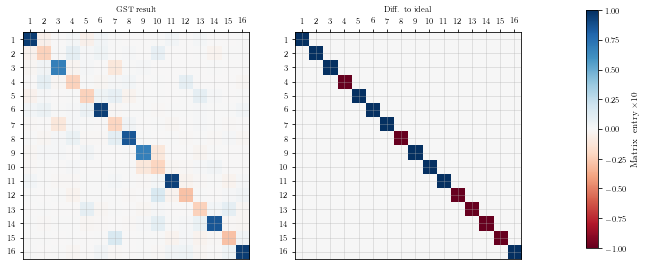

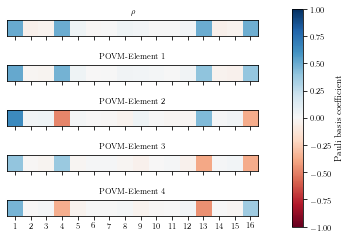

In [16]:
gate_index = 5

X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt,E_opt,rho_opt)
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'pp')


plot_mat(X_opt[gate_index], X_t[gate_index])
plot_spam(rho_opt_pp, E_opt_pp)

Assignment fidelity for ideal basis state 0: 0.7869247556121024


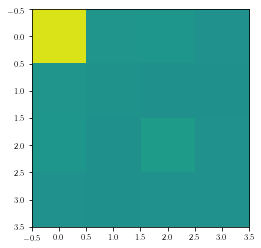

Assignment fidelity for ideal basis state 1: 0.9387900813018228


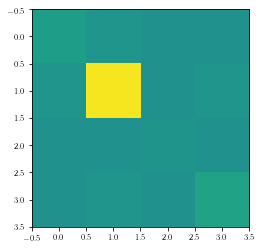

Assignment fidelity for ideal basis state 2: 0.5851680399223098


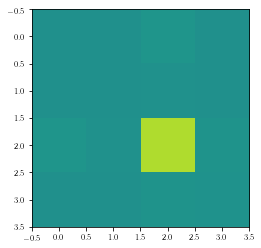

Assignment fidelity for ideal basis state 3: 0.673848099928426


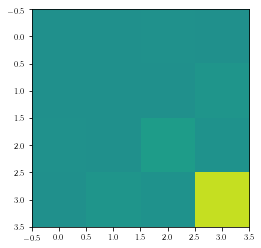

In [11]:
for i in range(4):
    print("Assignment fidelity for ideal basis state %i:"%i, np.abs(E_opt.reshape(4,4,4)[i,i,i])**2)
    plt.imshow(np.abs(E_opt.reshape(4,4,4)[i,:,:]), vmin = -1, vmax = 1)
    plt.show()

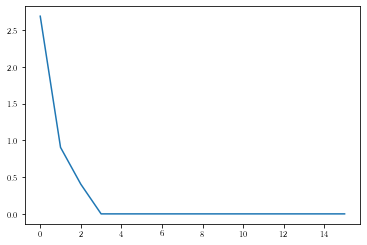

In [17]:
# Spectrum of the Choi matrix
X_choi = X_opt.reshape(d,pdim,pdim,pdim,pdim)
X_choi = np.einsum('ijklm->iljmk',X_choi).reshape(d,pdim**2,pdim**2)
plt.plot(np.sort(np.abs(la.eig(X_choi[5])[0]))[::-1])

In [18]:
from qiskit.quantum_info import entanglement_of_formation

plus_plus = np.outer(np.array([1,1,1,1])/2,np.array([1,1,1,1])/2).reshape(-1)

print(entanglement_of_formation((X_opt[5]@plus_plus).reshape(4,4)))

0.012591550652701854


### Rank 4

In [19]:
with open("ranks_4_from_init", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [20]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CNOT[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,98466","0,04937"
Rx(pi/2)[q0],"0,97724","0,08978"
Ry(pi/2)[q0],"0,97419","0,09854"
Rx(pi/2)[q1],"0,94845","0,16368"
Ry(pi/2)[q1],"0,95050","0,14989"
CNOT[q0-q1],"0,37837","0,94874"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.003927,0.079855,0.221379,0.699667,0.997707


(None, None)

### Rank 1

In [21]:
with open("ranks_1_from_init", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [22]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CNOT[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99887","0,04965"
Rx(pi/2)[q0],"0,99895","0,04879"
Ry(pi/2)[q0],"0,99658","0,08090"
Rx(pi/2)[q1],"0,99130","0,11573"
Ry(pi/2)[q1],"0,99131","0,12613"
CNOT[q0-q1],"0,34751","1,00000"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006190,0.102545,0.221379,0.153570,0.192942


(None, None)

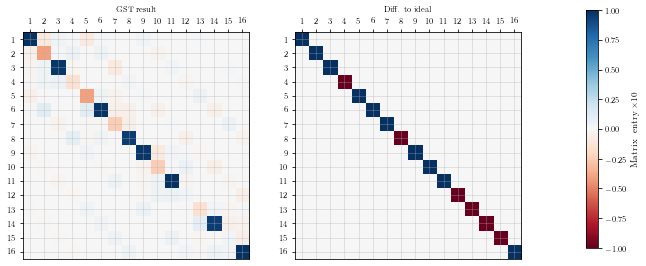

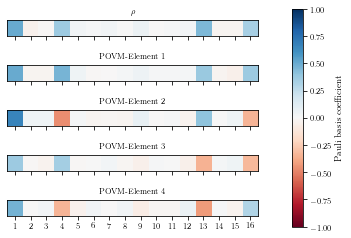

In [23]:
gate_index = 5

X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt,E_opt,rho_opt)
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'pp')


plot_mat(X_opt[gate_index], X_t[gate_index])
plot_spam(rho_opt_pp, E_opt_pp)

In [24]:
K_opt = additional_fns.Kraus_rep(X_opt,d,pdim,1)

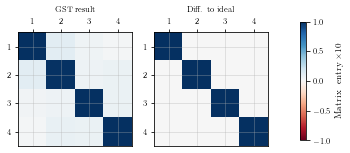

In [35]:
plot_mat(np.abs(K_opt[5][0]), np.abs(K_t[5][0]))

0.0
-2.0017198657014745
-0.18109969859314326
-1.7280166074641028


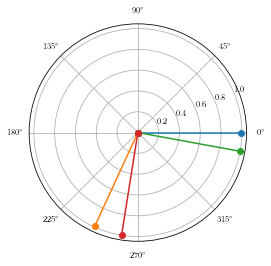

In [37]:
for x in np.diag(K_opt[5][0]):
    print(np.angle(x))
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()

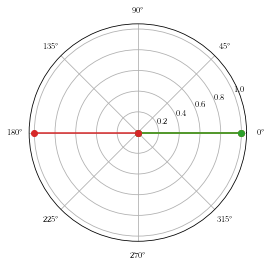

In [28]:
for x in np.diag(CZ):
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()